HDF5 版の XGBoost

In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
from BoschUtils import sampled_data_set, general_df, use_cols_list, entire_data_set
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
# 入力ファイルの皆さん

TRAINS = [
    "../hdf/train_date_reduced_L0_min_max.hdf",
    "../hdf/train_date_reduced_L1_min_max.hdf",
    "../hdf/train_date_reduced_L2_min_max.hdf",
    "../hdf/train_date_reduced_L3_min_max.hdf",
    "../hdf/train_date_reduced_min_max.hdf",
    "../hdf/train_categorical_reduced.hdf"
]

TESTS = []

for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
    
RESPONSE = "../hdf/train_response.hdf"

(0.18941979, 'min_max')
(0.12627986, 'L3_min_max')
(0.093856655, 'L0_min')
(0.090443686, 'L0_min_max')
(0.078498296, 'L3_min')
(0.0665529, 'L2_min')
(0.056313992, 'L3_S32_F3854')
(0.042662118, 'min')
(0.042662118, 'L1_min')
(0.039249148, 'L3_max')
(0.029010238, 'L1_max')
(0.023890786, 'L0_max')
(0.020477816, 'L1_min_max')
(0.020477816, 'L1_S25_F1903')
(0.015358361, 'L3_S29_F3475')
(0.013651877, 'L3_S47_F4141')
(0.013651877, 'L3_S29_F3317')
(0.010238908, 'L2_S26_F3099')
(0.0068259384, 'L2_S27_F3131')
(0.0051194541, 'L1_S25_F1981')
(0.0034129692, 'L1_S24_F1559')
(0.0034129692, 'L1_S24_F1525')
(0.0017064846, 'L3_S32_F3851')
(0.0017064846, 'L1_S25_F2779')
(0.0017064846, 'L1_S25_F1852')
(0.0017064846, 'L1_S24_F675')
(0.0017064846, 'L1_S24_F1584')


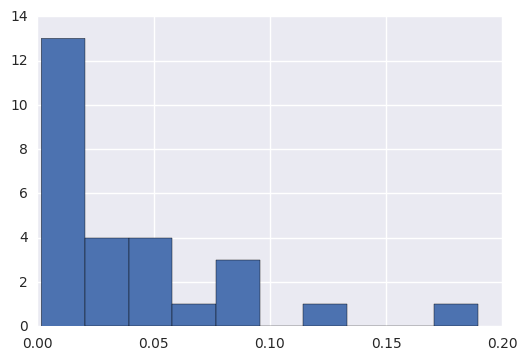

In [27]:
# 重要度を見てみる
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
X = X.sample(frac=0.05)
columns = X.columns
y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)
plt.hist(clf.feature_importances_[clf.feature_importances_>0])

tuples = []
for i in range(len(columns)):
    fi = clf.feature_importances_[i]
    if fi <= 0.001:
        continue
    tuples.append((fi, columns[i]))
    
tuples = sorted(tuples, reverse=True)
for t in tuples:
    print(t)

In [8]:
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
y = pd.read_hdf(RESPONSE)

In [9]:
X = X.values
y = y.values.ravel()

In [10]:
# 予測して Cross Validation
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.694
fold 1, ROC AUC: 0.689
fold 2, ROC AUC: 0.674
0.685482423355


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.0611189518709


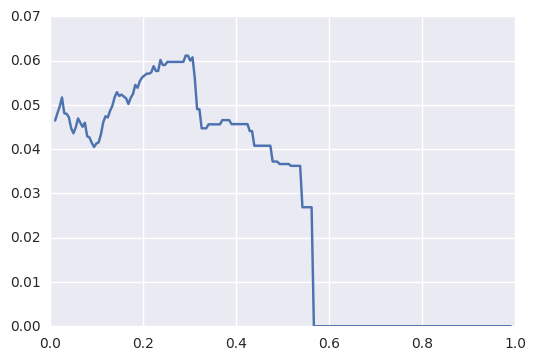

In [11]:
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [13]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_hdf(RESPONSE)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,9,1176859
1.0,33,6846


提出用データを生成する

In [17]:
# テストデータ読み込み
X = pd.concat((pd.read_hdf(filename) for filename in TESTS), axis=1)
index = X.index
X = X.values
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

# 提出データを生成
sub = pd.DataFrame(index=index, columns=[])
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")